In [1]:
cd ..

/Users/zachjakobsen/Documents/CPEN-400Q/UnsupGenModbyMPS


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp

import jax.numpy as jnp
import optax
import jax

from MPScumulant import MPS_c
import mps_circuit_helpers as helpers
import mps_circuit
import metrics

%load_ext autoreload

Load and format the data

In [3]:
data = np.load('BStest/BSdata.npy')
data_states = data.reshape(-1, 16).astype(np.int8)

Load the trained MPS - the full unbounded one this time!

In [4]:
%autoreload
m = MPS_c(16, max_bond_dim=300)
m.loadMPS('BS-MPS')

# check the properties of the matrices in the MPS
for i in range(len(m.matrices)):
    tn_core = m.matrices[i]
    print(i, tn_core.shape)

0 (1, 2, 2)
1 (2, 2, 4)
2 (4, 2, 8)
3 (8, 2, 15)
4 (15, 2, 16)
5 (16, 2, 16)
6 (16, 2, 16)
7 (16, 2, 15)
8 (15, 2, 16)
9 (16, 2, 16)
10 (16, 2, 16)
11 (16, 2, 15)
12 (15, 2, 8)
13 (8, 2, 4)
14 (4, 2, 2)
15 (2, 2, 1)


In [5]:
m_pad = helpers.pad_mps(m)

# check the properties of the matrices in the paddded MPS
for i in range(len(m_pad.matrices)):
    tn_core = m_pad.matrices[i]
    print(i, tn_core.shape)

idx, shape of the padded tensor, updated bond dimension
i = 1, (2, 2, 4), 2
i = 2, (4, 2, 8), 4
i = 3, (8, 2, 16), 8
i = 4, (16, 2, 16), 16
i = 5, (16, 2, 16), 16
i = 6, (16, 2, 16), 16
i = 7, (16, 2, 16), 16
i = 8, (16, 2, 16), 16
i = 9, (16, 2, 16), 16
i = 10, (16, 2, 16), 16
i = 11, (16, 2, 16), 16
i = 12, (16, 2, 8), 16
i = 13, (8, 2, 4), 8
i = 14, (4, 2, 2), 4
0 (1, 2, 2)
1 (2, 2, 4)
2 (4, 2, 8)
3 (8, 2, 16)
4 (16, 2, 16)
5 (16, 2, 16)
6 (16, 2, 16)
7 (16, 2, 16)
8 (16, 2, 16)
9 (16, 2, 16)
10 (16, 2, 16)
11 (16, 2, 16)
12 (16, 2, 8)
13 (8, 2, 4)
14 (4, 2, 2)
15 (2, 2, 1)


In [6]:
# check for isometries by reshaping along axis 0
helpers.are_isometries(m_pad)

idx, core tensor shape, left isometry, right isometry
0 (1, 2, 2) True True
1 (2, 2, 4) True True
2 (4, 2, 8) True True
3 (8, 2, 16) False False
4 (16, 2, 16) True False
5 (16, 2, 16) True False
6 (16, 2, 16) True False
7 (16, 2, 16) False False
8 (16, 2, 16) True False
9 (16, 2, 16) True False
10 (16, 2, 16) True False
11 (16, 2, 16) False False
12 (16, 2, 8) True False
13 (8, 2, 4) True False
14 (4, 2, 2) False False
15 (2, 2, 1) False False


In [7]:
# left canonicalize the padded MPS
m_pad.left_cano()

# check for isometries by reshaping along axis 0
helpers.are_isometries(m_pad)

bond: 0
bond: 1
bond: 2
bond: 3
bond: 4
bond: 5
bond: 6
bond: 7
bond: 8
bond: 9
bond: 10
bond: 11
bond: 12
bond: 13
bond: 14
idx, core tensor shape, left isometry, right isometry
0 (1, 2, 2) True True
1 (2, 2, 4) True True
2 (4, 2, 8) True True
3 (8, 2, 16) True True
4 (16, 2, 16) True False
5 (16, 2, 16) True False
6 (16, 2, 16) True False
7 (16, 2, 16) True False
8 (16, 2, 16) True False
9 (16, 2, 16) True False
10 (16, 2, 16) True False
11 (16, 2, 16) True False
12 (16, 2, 8) True False
13 (8, 2, 4) True False
14 (4, 2, 2) True False
15 (2, 2, 1) True False


In [8]:
unitary_list = []
tn_cores = m_pad.matrices
for site_idx in range(len(tn_cores)):
    tn_core = tn_cores[site_idx]
    # this step assumes that the core tensor is a left isometry
    u_mat = helpers.isometry_to_unitary(tn_core.reshape(-1, tn_core.shape[2]))
    unitary_list.append(u_mat)

In [9]:
# check if all matrices in the list are unitaries
for mat in unitary_list:
    print(helpers.is_unitary(mat), mat.shape)

True (2, 2)
True (4, 4)
True (8, 8)
True (16, 16)
True (32, 32)
True (32, 32)
True (32, 32)
True (32, 32)
True (32, 32)
True (32, 32)
True (32, 32)
True (32, 32)
True (32, 32)
True (16, 16)
True (8, 8)
True (4, 4)


Implement the bottom-left to top-right staircase circuit with correct indexing

In [10]:
truncated_unitary_list = unitary_list[1:]
n_wires = len(truncated_unitary_list) + 1
dev = qml.device("default.qubit", wires=n_wires, shots=None)

@qml.qnode(dev)
def mps_circ():
    for wire in range(n_wires-1, -1, -1):
        unitary = unitary_list[wire]
        n_qubits = int(np.log2(unitary.shape[0]))
        u_wires = [wire] + list(range(wire-1, wire-n_qubits, -1))
        u_wires.reverse()
        qml.QubitUnitary(unitary, wires=u_wires)
    return qml.probs(wires=range(n_wires))

(<Figure size 1900x1700 with 1 Axes>, <Axes: >)

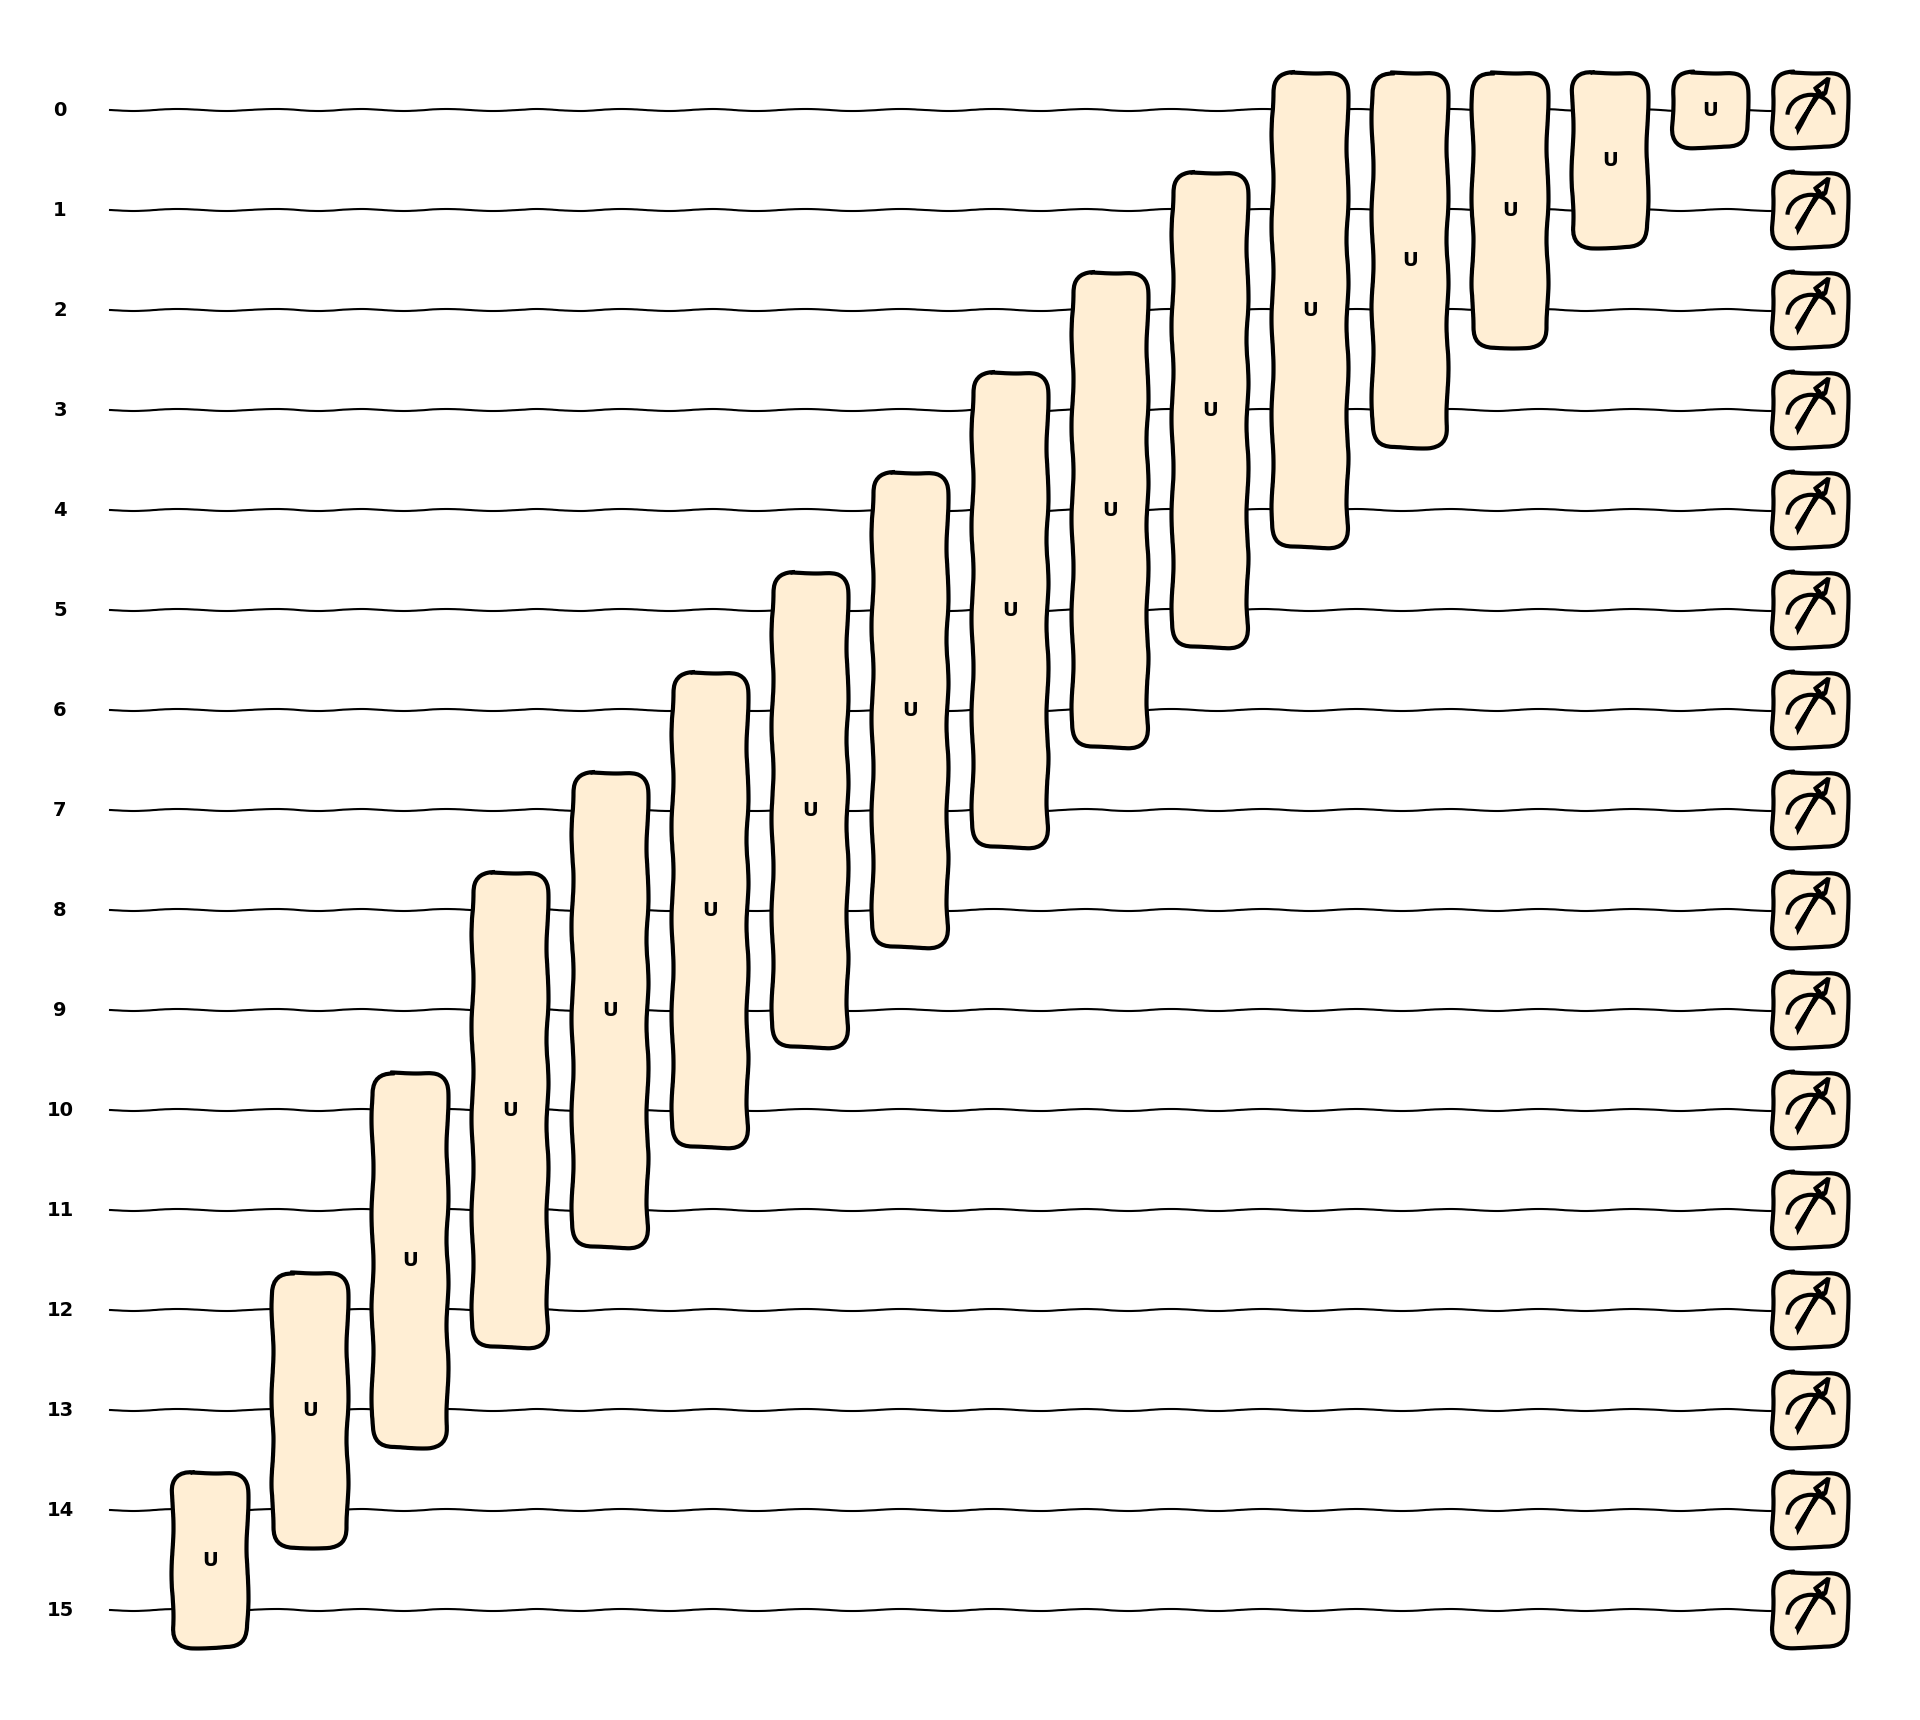

In [11]:
qml.drawer.draw_mpl(mps_circ, style="sketch")()

In [12]:
qc_probs = mps_circ()
filter_qc_probs = metrics.filter_probs(qc_probs, data_states)
metrics.kl_divergence_synergy_paper(30, filter_qc_probs)

Array(2.3841858e-07, dtype=float32)

Why tf is this different when the kl-divergence is the same for the chi = 2 MPS ?

In [13]:
mps_probs_states = m.Give_probab(data_states)
metrics.kl_divergence_synergy_paper(30, mps_probs_states)

Array(2.3841858e-07, dtype=float32)

In [14]:
mps_probs_states = m_pad.Give_probab(data_states)
metrics.kl_divergence_synergy_paper(30, mps_probs_states)

Array(2.3841858e-07, dtype=float32)

Padded MPS has the same KL-divergence but not the mapped PQC. Why ? How about chi = 4 MPS ?

In [15]:
%autoreload
m = MPS_c(16, max_bond_dim=4)
m.loadMPS('BS-4-MPS')

# check the properties of the matrices in the MPS
for i in range(len(m.matrices)):
    tn_core = m.matrices[i]
    print(i, tn_core.shape)

0 (1, 2, 2)
1 (2, 2, 4)
2 (4, 2, 4)
3 (4, 2, 4)
4 (4, 2, 4)
5 (4, 2, 4)
6 (4, 2, 4)
7 (4, 2, 4)
8 (4, 2, 4)
9 (4, 2, 4)
10 (4, 2, 4)
11 (4, 2, 4)
12 (4, 2, 4)
13 (4, 2, 4)
14 (4, 2, 2)
15 (2, 2, 1)


In [16]:
m_pad = helpers.pad_mps(m)

# left canonicalize the padded MPS
m_pad.left_cano()

unitary_list = []
tn_cores = m_pad.matrices
for site_idx in range(len(tn_cores)):
    tn_core = tn_cores[site_idx]
    # this step assumes that the core tensor is a left isometry
    u_mat = helpers.isometry_to_unitary(tn_core.reshape(-1, tn_core.shape[2]))
    unitary_list.append(u_mat)

idx, shape of the padded tensor, updated bond dimension
i = 1, (2, 2, 4), 2
i = 2, (4, 2, 4), 4
i = 3, (4, 2, 4), 4
i = 4, (4, 2, 4), 4
i = 5, (4, 2, 4), 4
i = 6, (4, 2, 4), 4
i = 7, (4, 2, 4), 4
i = 8, (4, 2, 4), 4
i = 9, (4, 2, 4), 4
i = 10, (4, 2, 4), 4
i = 11, (4, 2, 4), 4
i = 12, (4, 2, 4), 4
i = 13, (4, 2, 4), 4
i = 14, (4, 2, 2), 4
bond: 0
bond: 1
bond: 2
bond: 3
bond: 4
bond: 5
bond: 6
bond: 7
bond: 8
bond: 9
bond: 10
bond: 11
bond: 12
bond: 13
bond: 14


In [17]:
# check if all matrices in the list are unitaries
for mat in unitary_list:
    print(helpers.is_unitary(mat), mat.shape)

True (2, 2)
True (4, 4)
True (8, 8)
True (8, 8)
True (8, 8)
True (8, 8)
True (8, 8)
True (8, 8)
True (8, 8)
True (8, 8)
True (8, 8)
True (8, 8)
True (8, 8)
True (8, 8)
True (8, 8)
True (4, 4)


Same left-to-right and bottom-to-up staircase for chi = 4

In [18]:
truncated_unitary_list = unitary_list[1:]
n_wires = len(truncated_unitary_list) + 1
dev = qml.device("default.qubit", wires=n_wires, shots=None)

@qml.qnode(dev)
def mps_circ():
    for wire in range(n_wires-2, -1, -1):
        unitary = truncated_unitary_list[wire]
        n_qubits = int(np.log2(unitary.shape[0]))
        u_wires = [wire] + list(range(wire+1, wire+n_qubits, 1))
        qml.QubitUnitary(unitary, wires=u_wires)
    # add the unitary for site 0 separately
    qml.QubitUnitary(unitary_list[0], wires=[0])
    return qml.probs(wires=range(n_wires))

In [19]:
qc_probs = mps_circ()
filter_qc_probs = metrics.filter_probs(qc_probs, data_states)
metrics.kl_divergence_synergy_paper(30, filter_qc_probs)

Array(11.563138, dtype=float32)

(<Figure size 1900x1700 with 1 Axes>, <Axes: >)

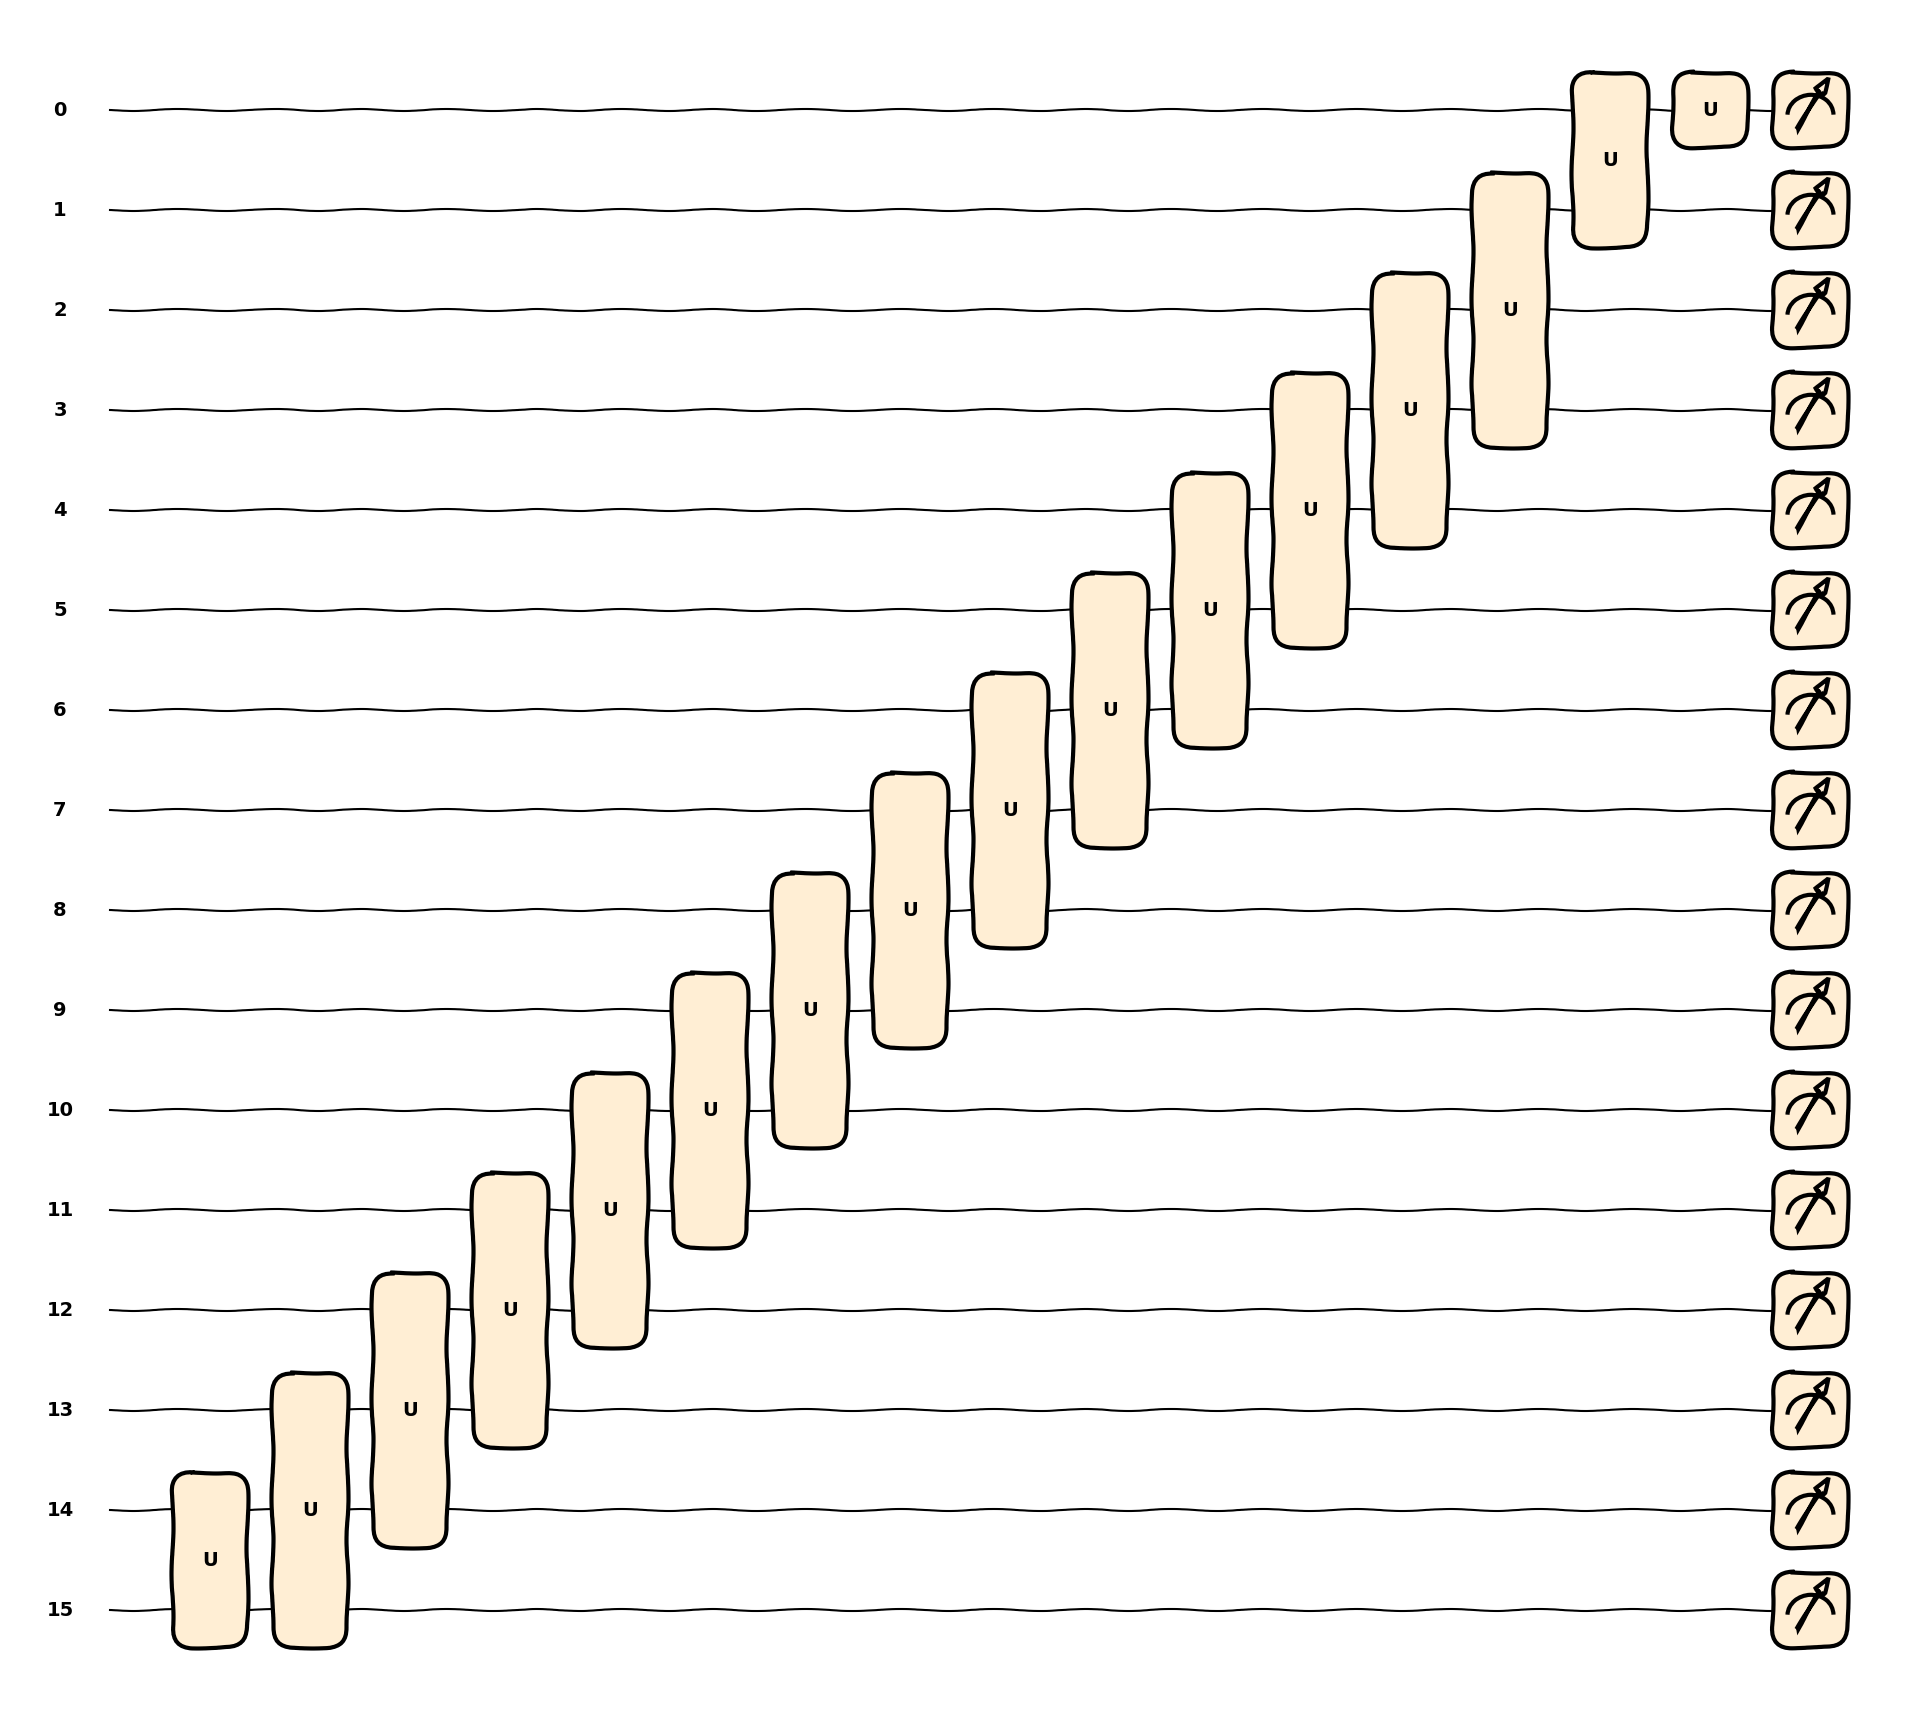

In [20]:
qml.drawer.draw_mpl(mps_circ, style="sketch")()

Even this one doesn't work - so somehow we only have found the working solution for chi = 2 MPS. I think we can see the problem above when we compare this circuit to the one in the decomposition paper.

In [21]:
truncated_unitary_list = unitary_list[1:]
n_wires = len(truncated_unitary_list) + 1
dev = qml.device("default.qubit", wires=n_wires, shots=None)

@qml.qnode(dev)
def mps_circ():
    for wire in range(n_wires-1, -1, -1):
        unitary = unitary_list[wire]
        n_qubits = int(np.log2(unitary.shape[0]))
        u_wires = [wire] + list(range(wire-1, wire-n_qubits, -1))
        u_wires.reverse()
        qml.QubitUnitary(unitary, wires=u_wires)
    return qml.probs(wires=range(n_wires))

(<Figure size 1900x1700 with 1 Axes>, <Axes: >)

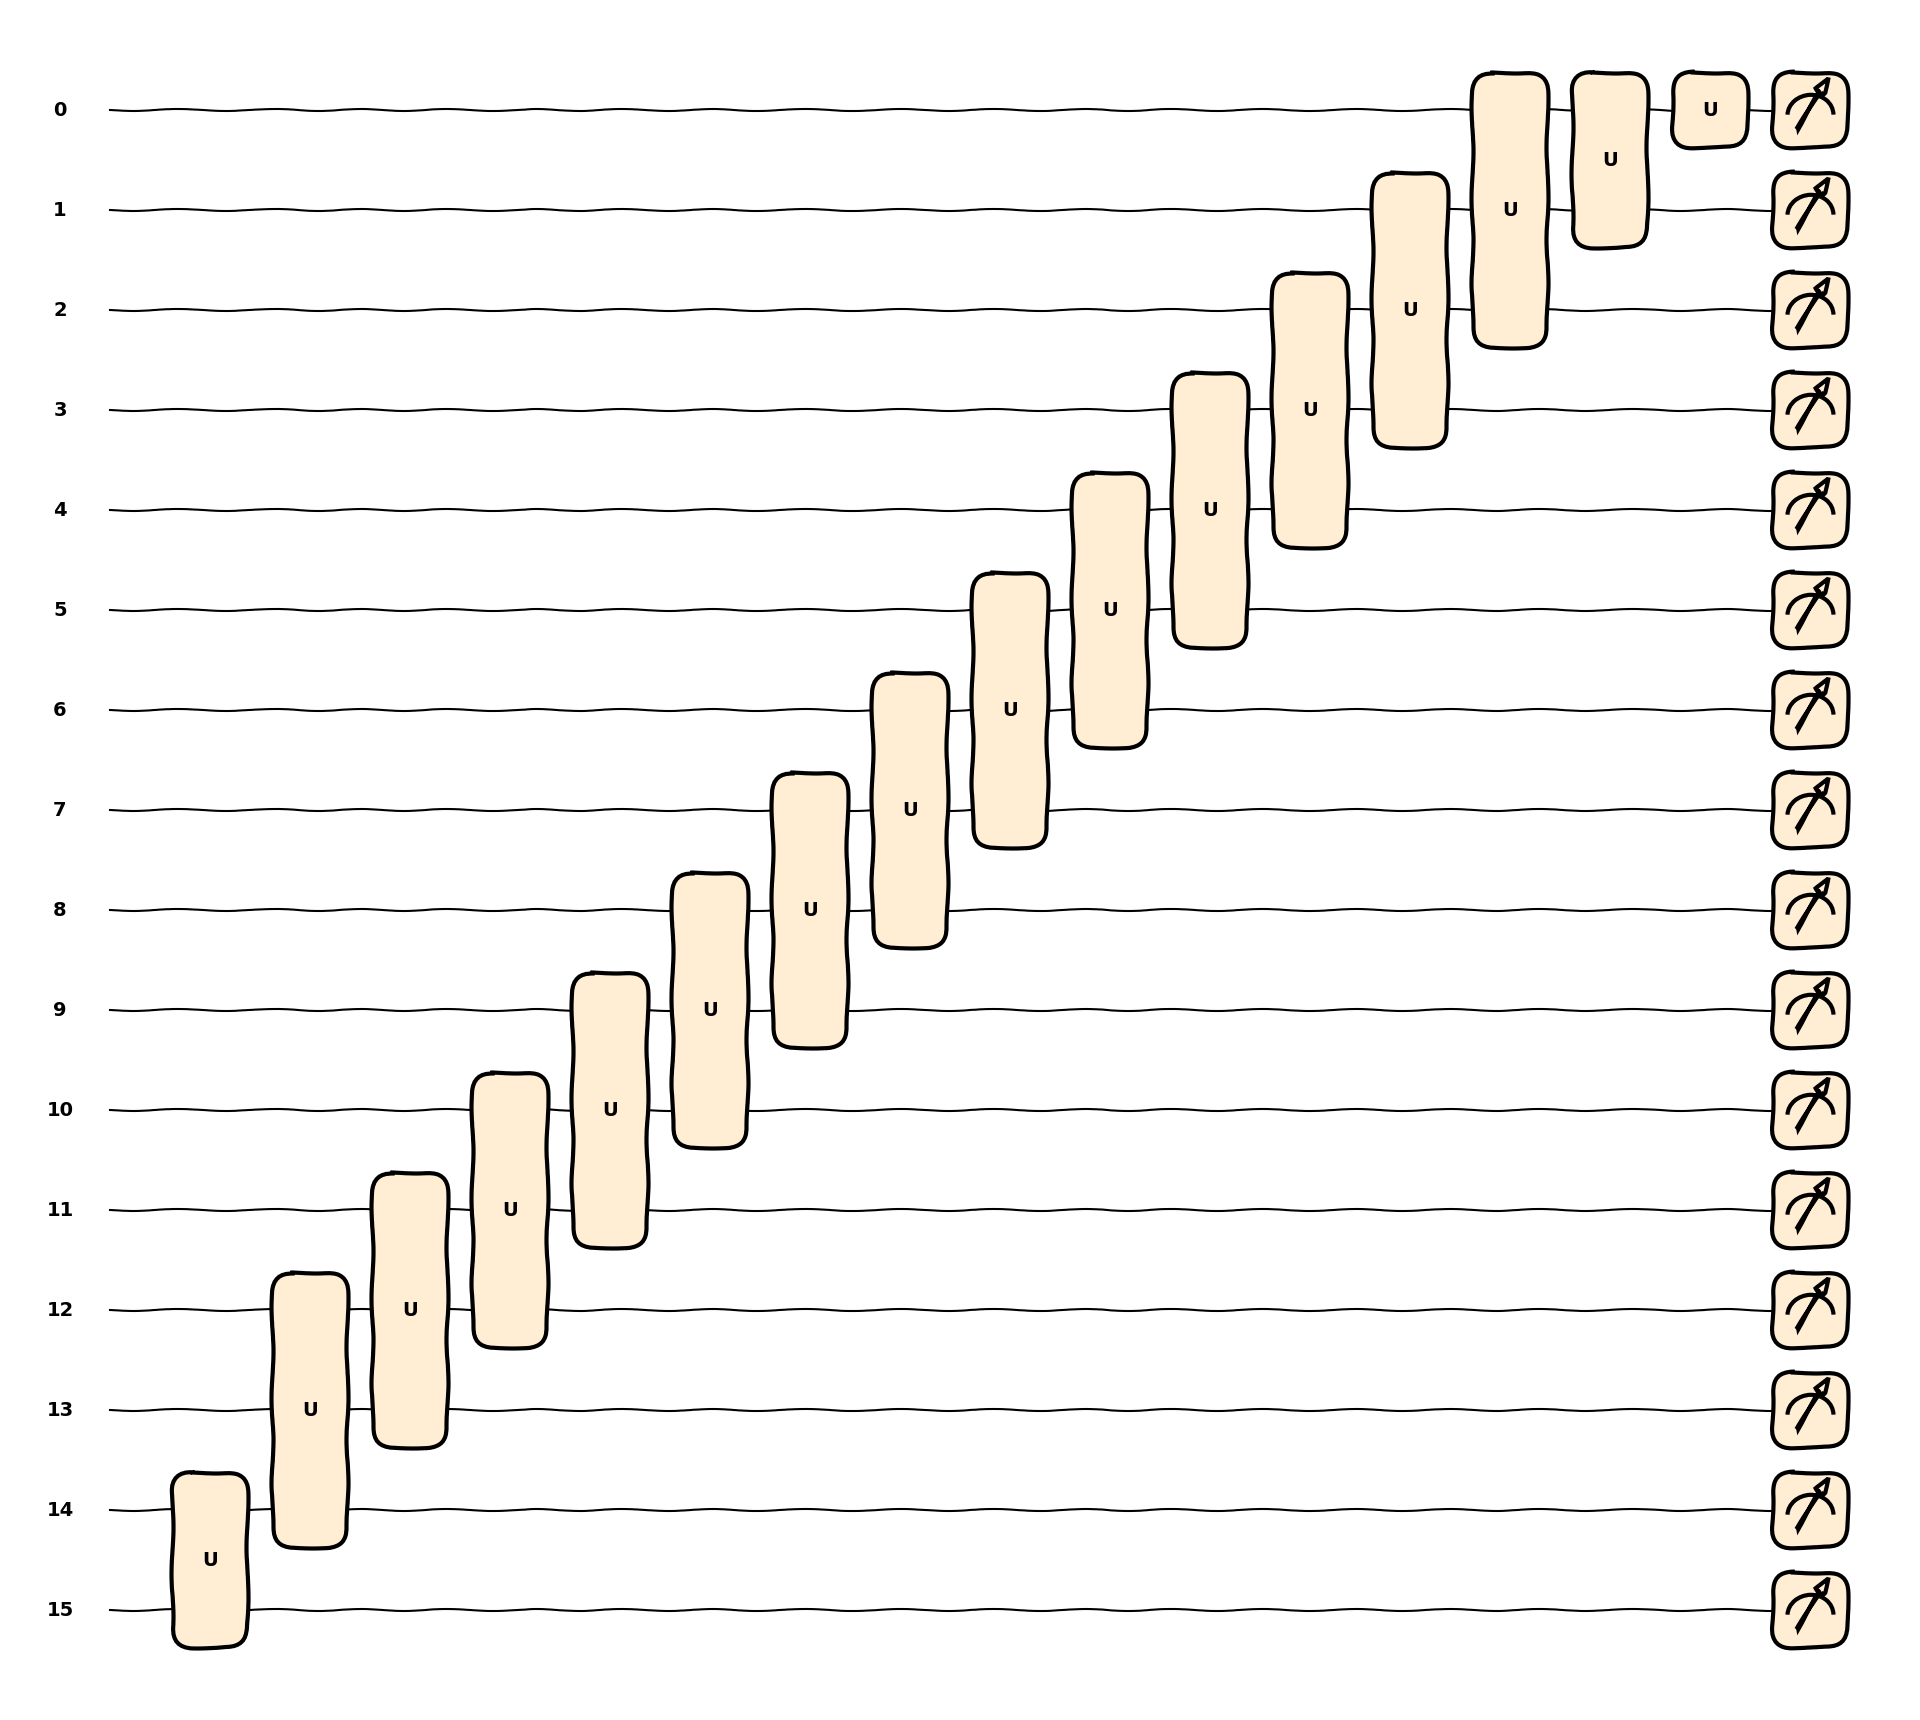

In [22]:
qml.drawer.draw_mpl(mps_circ, style="sketch")()

In [23]:
qc_probs = mps_circ()
filter_qc_probs = metrics.filter_probs(qc_probs, data_states)
metrics.kl_divergence_synergy_paper(30, filter_qc_probs)

Array(2.808178, dtype=float32)

What we're trying to achieve :

In [24]:
mps_probs_states = m.Give_probab(data_states)
metrics.kl_divergence_synergy_paper(30, mps_probs_states)

Array(2.808178, dtype=float32)

In [25]:
mps_probs_states = m_pad.Give_probab(data_states)
metrics.kl_divergence_synergy_paper(30, mps_probs_states)

Array(2.808178, dtype=float32)

Yes - finally it does work for all cases! Let's try to plot some nice samples!

In [26]:
truncated_unitary_list = unitary_list[1:]
n_wires = len(truncated_unitary_list) + 1
dev = qml.device("default.qubit", wires=n_wires, shots=1024)

@qml.qnode(dev)
def mps_circ():
    for wire in range(n_wires-1, -1, -1):
        unitary = unitary_list[wire]
        n_qubits = int(np.log2(unitary.shape[0]))
        u_wires = [wire] + list(range(wire-1, wire-n_qubits, -1))
        u_wires.reverse()
        qml.QubitUnitary(unitary, wires=u_wires)
    return qml.sample()

Frequency : 1
Frequency : 36
Frequency : 35
Frequency : 32
Frequency : 31
Frequency : 31
Frequency : 31
Frequency : 30
Frequency : 30
Frequency : 30
Frequency : 29
Frequency : 27
Frequency : 25
Frequency : 23
Frequency : 22
Frequency : 21
Frequency : 17
Frequency : 6
Frequency : 4
Frequency : 4
Frequency : 3
Frequency : 3
Frequency : 3
Frequency : 3
Frequency : 3
Frequency : 2
Frequency : 2
Frequency : 2
Frequency : 2
Frequency : 2


(<Figure size 1800x1500 with 30 Axes>, <Axes: >)

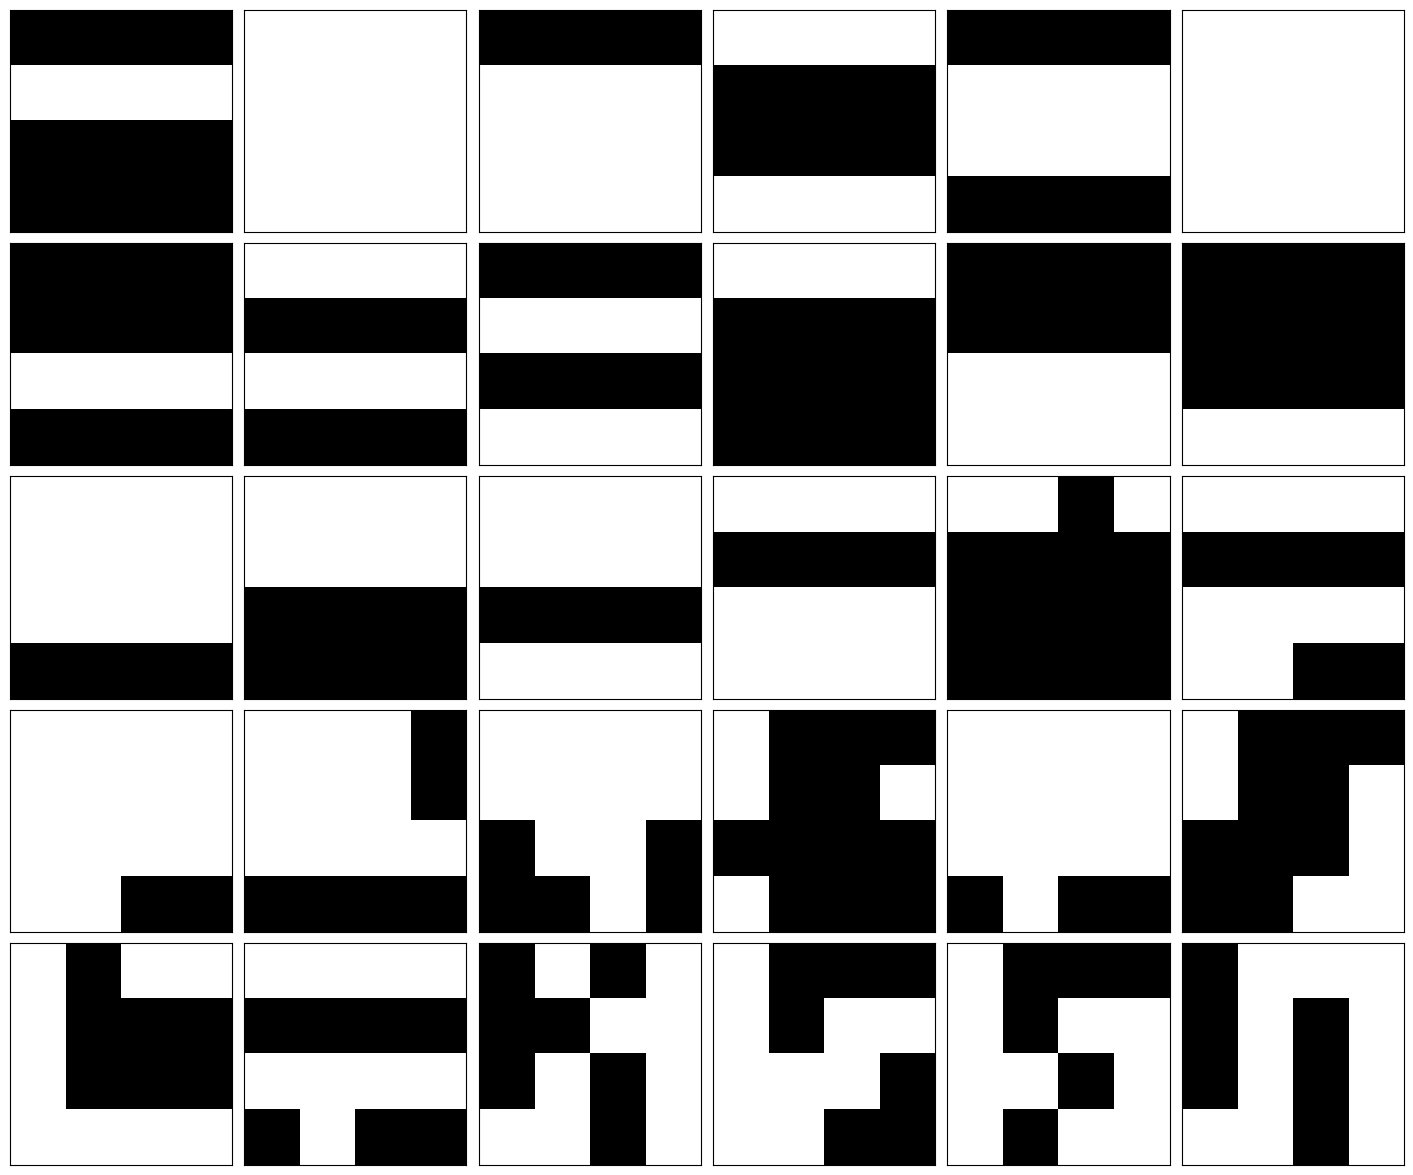

In [27]:
%autoreload
metrics.plot_top_samples(mps_circ())

Perfect! The samples are being neatly reproduced now.

In [28]:
%autoreload
mps_unitaries = helpers.get_mps_unitaries(m)
circ = mps_circuit.mps_unitaries_to_circuit(mps_unitaries)

padding the mps core tensors
idx, shape of the padded tensor, updated bond dimension
i = 1, (2, 2, 4), 2
i = 2, (4, 2, 4), 4
i = 3, (4, 2, 4), 4
i = 4, (4, 2, 4), 4
i = 5, (4, 2, 4), 4
i = 6, (4, 2, 4), 4
i = 7, (4, 2, 4), 4
i = 8, (4, 2, 4), 4
i = 9, (4, 2, 4), 4
i = 10, (4, 2, 4), 4
i = 11, (4, 2, 4), 4
i = 12, (4, 2, 4), 4
i = 13, (4, 2, 4), 4
i = 14, (4, 2, 2), 4
left canonicalizing the padded MPS
bond: 0
bond: 1
bond: 2
bond: 3
bond: 4
bond: 5
bond: 6
bond: 7
bond: 8
bond: 9
bond: 10
bond: 11
bond: 12
bond: 13
bond: 14


(<Figure size 1900x1700 with 1 Axes>, <Axes: >)

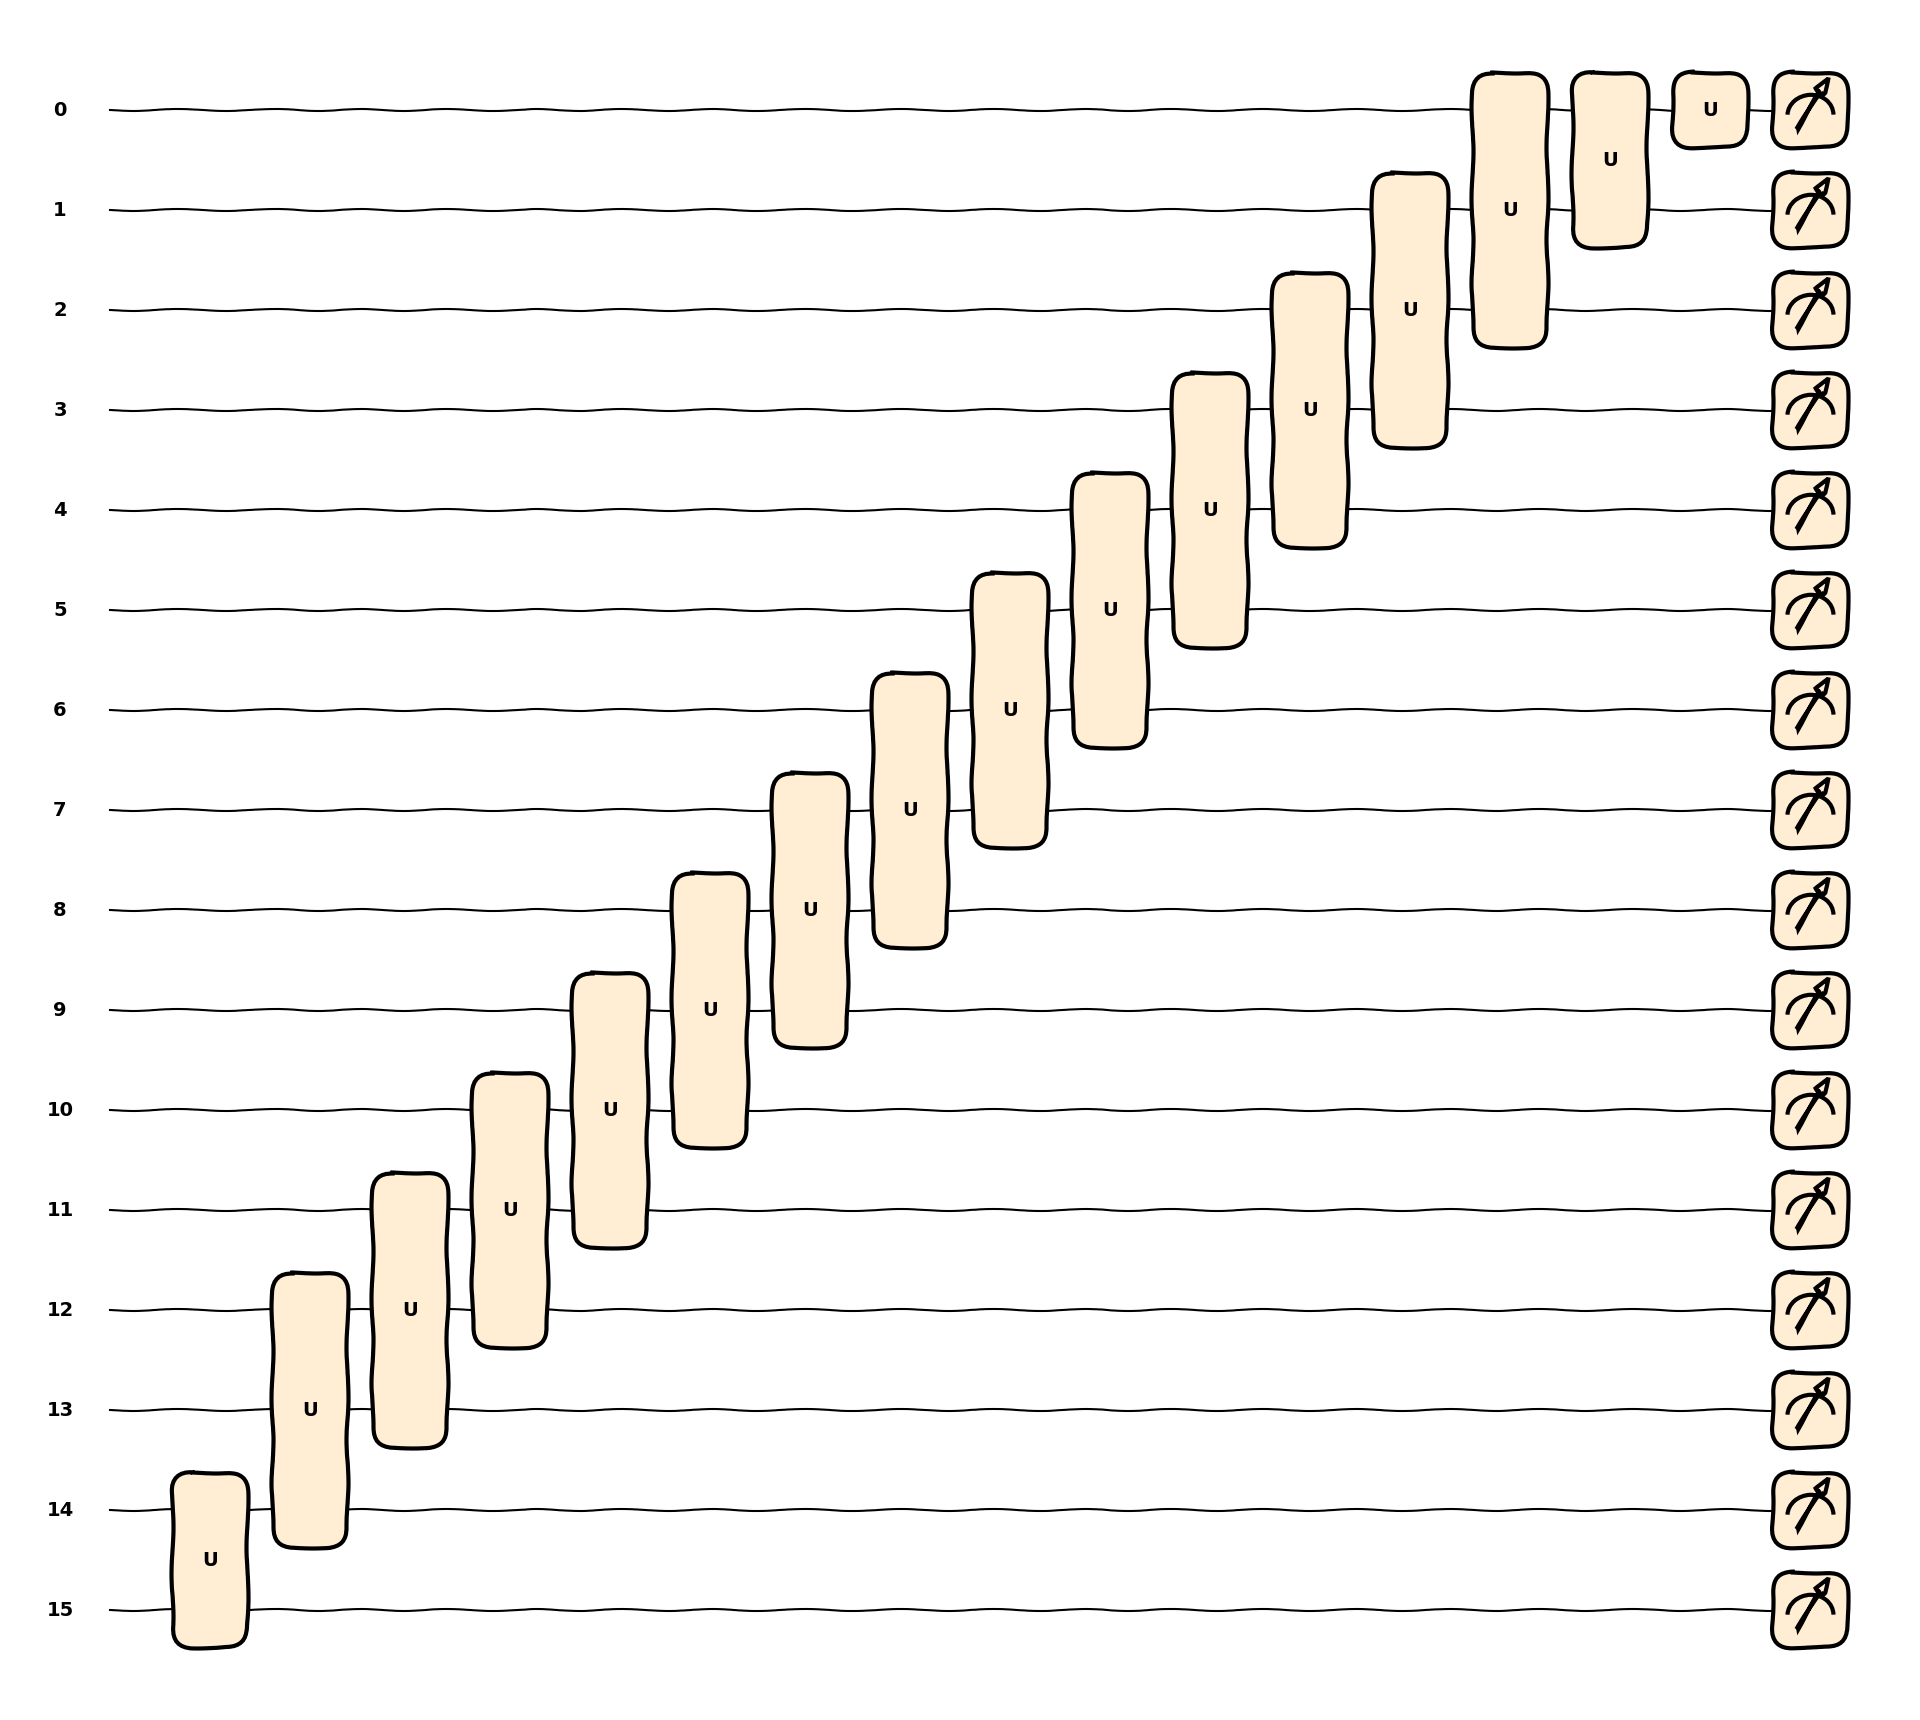

In [29]:
qml.drawer.draw_mpl(mps_circ, style="sketch")()

In [30]:
qc_probs = circ()
filter_qc_probs = metrics.filter_probs(qc_probs, data_states)
metrics.kl_divergence_synergy_paper(30, filter_qc_probs)

Array(2.808178, dtype=float32)

Frequency : 1
Frequency : 36
Frequency : 35
Frequency : 32
Frequency : 31
Frequency : 31
Frequency : 31
Frequency : 30
Frequency : 30
Frequency : 30
Frequency : 29
Frequency : 27
Frequency : 25
Frequency : 23
Frequency : 22
Frequency : 21
Frequency : 17
Frequency : 6
Frequency : 4
Frequency : 4
Frequency : 3
Frequency : 3
Frequency : 3
Frequency : 3
Frequency : 3
Frequency : 2
Frequency : 2
Frequency : 2
Frequency : 2
Frequency : 2


(<Figure size 1800x1500 with 30 Axes>, <Axes: >)

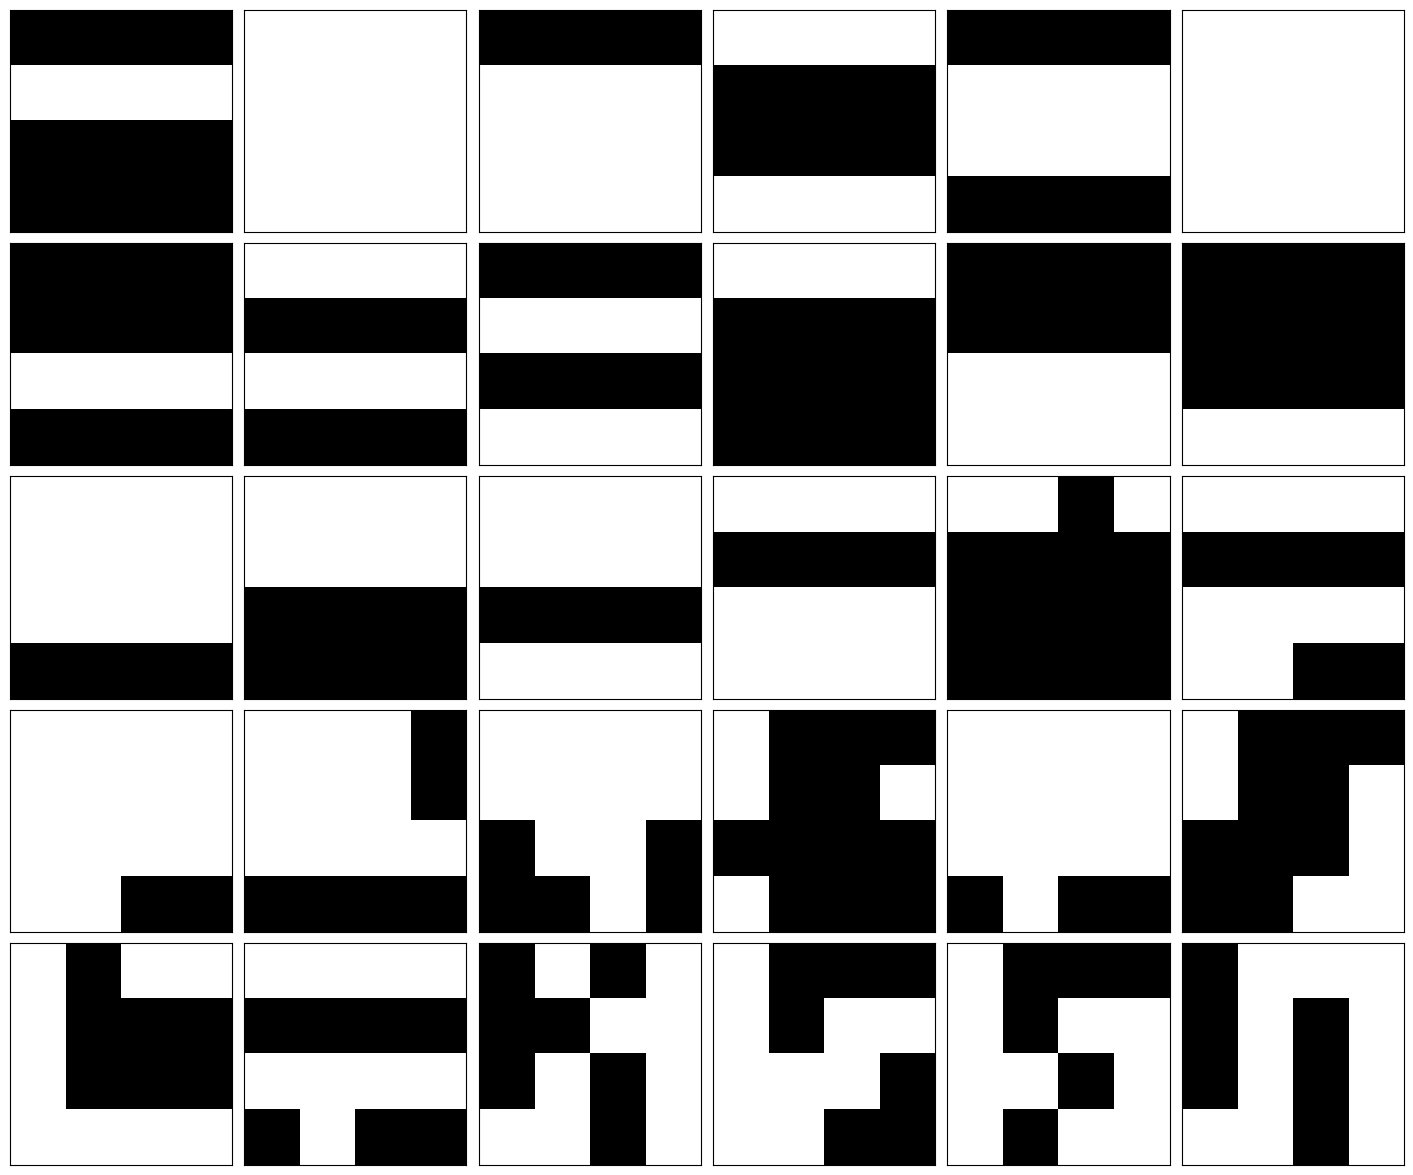

In [31]:
%autoreload
sampler_circ = mps_circuit.mps_unitaries_to_circuit(mps_unitaries, shots=1024)
metrics.plot_top_samples(sampler_circ())

Works now!

In [32]:
probs = circ()
kl_div = metrics.kl_divergence(probs, data)
print(kl_div)

28.031342


Extended Circuit

In [37]:
n_qubits = 5
n_wires = 16
wire = 1
u_wires = [wire] + list(range(wire+1, wire+n_qubits))
n_wires = len(mps_unitaries)
weights = jnp.array(pnp.random.normal(size=(4, 16), requires_grad=True))
shots = None
dev = qml.device("default.qubit", wires=n_wires, shots=shots)

def entangler(wires):
    for i in wires:
        if (i+1) in wires:
            qml.CNOT(wires=[i, i+1])
        else:
            qml.CNOT(wires=[i, 0])

@qml.qnode(dev, interface="jax")
def pqc_circuit(weights):

    for wire in range(n_wires-1, -1, -1):
        unitary = mps_unitaries[wire]
        n_qubits = int(np.log2(unitary.shape[0]))
        u_wires = [wire] + list(range(wire-1, wire-n_qubits, -1))
        u_wires.reverse()
        qml.QubitUnitary(unitary, wires=u_wires)

    for i in range(n_wires):
        qml.RX(weights[0, i], wires=i)
        qml.RZ(weights[1, i], wires=i)
    
    entangler(range(n_wires))
    
    for i in range(n_wires):
        qml.RZ(weights[2, i], wires=i)
        qml.RX(weights[3, i], wires=i)
        
    # return bitstring samples if number of shots specified
    if shots is not None:
        return qml.sample()
    # else return the probs of bitstrings
    return qml.probs(wires=range(n_wires))

@jax.jit
def loss(weights):
    data = np.load('BStest/BSdata.npy')
    data = data.astype(np.int32).reshape(-1, data.shape[1]*data.shape[2])   
    probs = pqc_circuit(weights)
    m=metrics.kl_divergence(probs, data)
    return m

n_its = 10

loss_track = []

opt_exc = optax.adam(0.1)
opt_state = opt_exc.init(weights)
for it in range(n_its):
    grads = jax.grad(loss)(weights)
    updates, opt_state = opt_exc.update(grads, opt_state)

    weights = optax.apply_updates(weights, updates)
    loss_track.append(loss(weights))

(<Figure size 3900x1700 with 1 Axes>, <Axes: >)

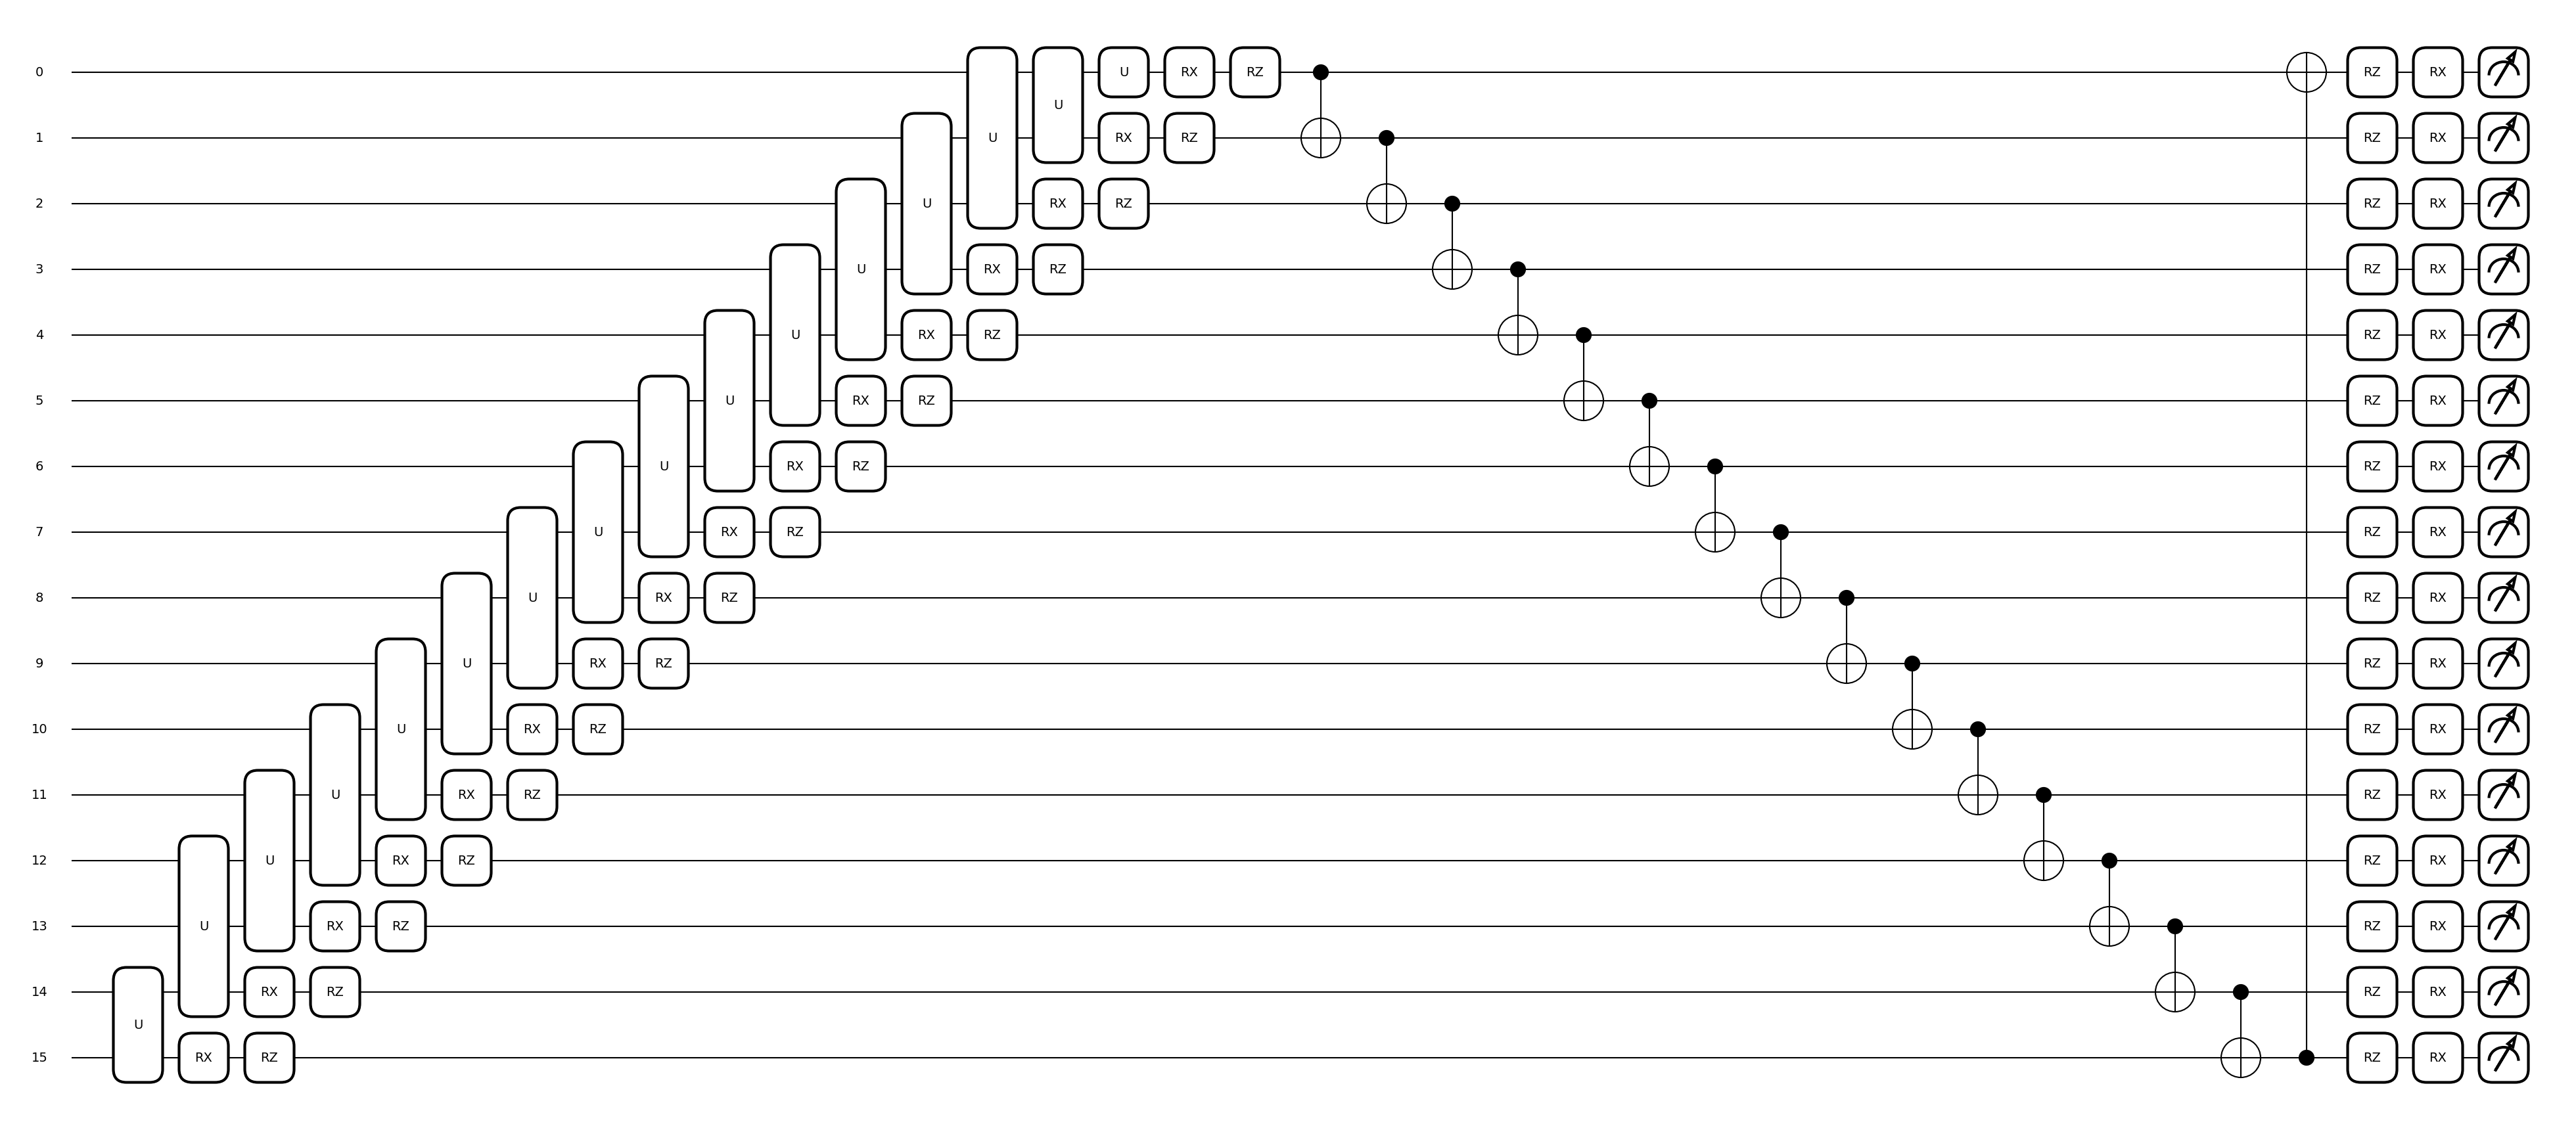

In [41]:
qml.drawer.draw_mpl(pqc_circuit)(weights)

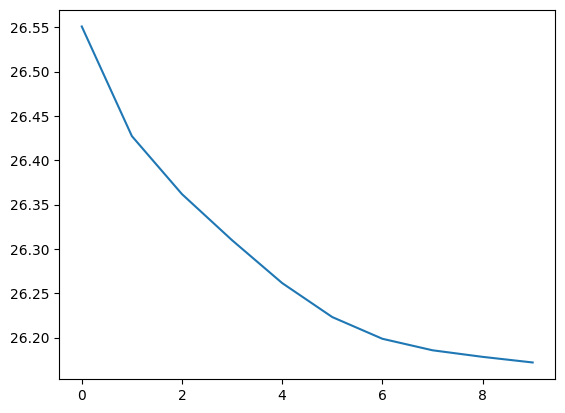

In [42]:
plt.plot(loss_track)